In [1]:
import freud
import gsd
import gsd.hoomd
import numpy as np

def msd_from_gsd(file, atom_type = 'all', skip_frames = 0, mode = 'direct'):
    '''
    Calculates a mean square displacement (MSD) of a trajectory.gsd file.
    Uses the gsd module to read and parse through the trajectory.gsd file,
    and uses the freud module to create the MSD.

    file: str, required
        The file name or path to the .gsd file

    atom_type: str, optional, default = 'all'
        If you want the MSD to be calculated between only certain atoms of the system, indicate their atom
        type here.

    skip_frames: int (or float), optional, default = 0
        The amount of frames of the trajectory.gsd that will be skipped before the MSD is determined.
        int: Can be entered as the total number of frames you want to skip (ex. 20 frames out of 100 total)
        float: Can be entered as a fraction of total frames to skip (ex. 20% of the total frames available)

    mode: str, optional, default = 'direct'
        Options include 'direct' and 'window'
        The mode descriptions are available in the Freud docs (https://freud.readthedocs.io/en/stable/msd.html)
    '''
    gsd_file = gsd.hoomd.open(file)
    system_snap = gsd_file.read_frame(-1)
    Lx, Ly, Lz, xy, xz, yz = system_snap.configuration.box
    box = freud.box.Box(Lx, Ly, Lz, xy, xz, yz)
    num_frames = gsd_file.file.nframes
    msd = freud.msd.MSD(box=box, mode=mode)

    if skip_frames < 1.0:  # skip_frames can be entered as a fraction if user doesn't know # of total frames
        skip_frames = int(num_frames * skip_frames)

    if atom_type == 'all':
        num_particles = system_snap.particles.N
        pos_array = np.empty([num_frames - skip_frames, num_particles, 3])
        img_array = np.empty([num_frames - skip_frames, num_particles, 3])
        for n in range(skip_frames, num_frames):
            snap = gsd_file.read_frame(n)
            pos_array[n - skip_frames, :, :] = snap.particles.position
            img_array[n - skip_frames, :, :] = snap.particles.image
    else:
        type_id = [i for i, n in enumerate(system_snap.particles.types) if n == atom_type]
        if not type_id:
            print('Atom type "{}" not found in the system'.format(atom_type))
            print('Available atom types in system = {}'.format(system_snap.particles.types))
            return
        num_particles = len([j for j in system_snap.particles.typeid if j == type_id])
        print('MSD of atom type {}'.format(system_snap.particles.types[type_id[0]]))
        print('# of {} type atoms in system = {}'.format(system_snap.particles.types[type_id[0]], num_particles))
        pos_array = np.empty([num_frames - skip_frames, num_particles, 3])
        img_array = np.empty([num_frames - skip_frames, num_particles, 3])
        for n in range(skip_frames, num_frames):
            atom_pos = []
            atom_img = []
            snap = gsd_file.read_frame(n)
            for num in range(0, snap.particles.N):
                if snap.particles.typeid[num] == type_id:
                    atom_pos.append(snap.particles.position[num])
                    atom_img.append(snap.particles.image[num])
            atom_pos_array = np.array(atom_pos)
            atom_img_array = np.array(atom_img)
            pos_array[n - skip_frames, :, :] = atom_pos_array
            img_array[n - skip_frames, :, :] = atom_img_array
    return(msd.accumulate(pos_array, images=img_array))


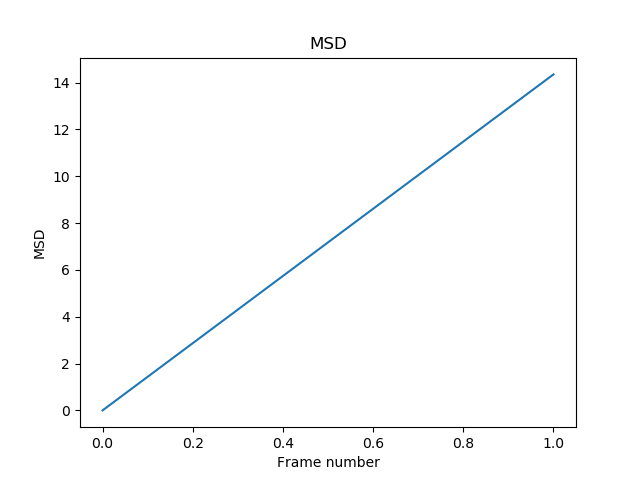

In [11]:
msd_from_gsd(file='trajectory-smalldt.gsd', skip_frames=11)